In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd
import copy

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
import smart
import coronagraph as cg
from jakely.plot import ColorTable

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _bspl
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:94: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ckdtree import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .qhull import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _voronoi
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/distance.py:121: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, go

Import local LUVOIR Habitable Exoplanet Characterization DRM code 

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

Import coupled VPL Earth Model - Coronagraph code

In [253]:
sys.path.insert(1, "../../exomapping/notebooks")

import ForwardMethods
from ForwardMethods import EarthModel, DataGenerator, bandwidth
from TimeTurner import TimeTurner

Setup DRM

In [5]:
# Create LUVOIR DRM
drmx = spectroscopy.HEC_DRM(
            wantSNR = 8.5,       # SNR desired on Ahr_flat spectrum
            wantexp = 365.,      # Maximum program duration desired
            Ahr_flat = 0.20,     # Flat spectrum albedo to get wantSNR
            eta_int = 0.1,       # Interesting target fraction
            bandwidth = 0.2,     # Bandpass bandwidth 
            architecture = "A",  # LUVOIR architecture "A" or "B"
            telescope_mods = {}  # Telescope noise model keyword arguments
)

# Calculate table of exposure times
drmx.generate_exptime_table()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:290: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:291: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:1272: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * 

In [6]:
drmx.exptime_table.head(10)

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4,Spec. Completeness
0,91772,K5,3.49174,4795.517824965829,75.73353763474026,6.3462790173350525,1.720068762812048,0.3819328392117149,0.5543561328159193,3.102920979635664,2.2914036519948295,2.8787579345547116,1.2889995547979307,0.9205597407736336,0.9315069755714868,1.2357242637754926,2.4024185417892148,1.0
1,8102,G8V,3.65017,nan,13.686116337416681,2.7254135148469625,1.1059591417647379,0.32824306743216625,0.5510146695788425,3.333782758654826,2.9813171027432204,4.318015826503313,2.1759176522792965,1.5301406018359995,1.725773609792996,2.5058206211671816,5.229663234076844,0.9782608695652174
2,85523,K5,4.5405,13307.690074663706,177.1110466235691,12.041609274395022,3.070540758432732,0.6672079929941587,0.9732329553664755,5.703126070002481,4.192129157201717,5.361640704165977,2.379442192394707,2.1813973334835133,2.269793862187854,3.13173114476341,6.43540063317844,1.0
3,99461,K2V,6.01504,5264.548226988776,124.59921859693902,12.736852605377115,4.00498060220363,1.0092487031848794,1.5966421392729795,10.148792548663488,8.295942165012518,11.740683448587141,5.512229556359268,6.5728940624166,7.47809522010468,11.23103183417392,25.032010105271706,1.0
4,12114,K3V,7.1803,19551.897543903164,331.00835816994066,24.228889972459097,6.649004894479273,1.5558278210305232,2.426393159887771,16.23737304168218,12.818969034145224,18.146065808883865,8.275970393974978,11.951161658936584,13.508864250800533,20.285919068098917,nan,0.8521739130434782
5,113283,K4Vp,7.60919,47381.83847109929,637.3368215649921,36.55267771766989,8.871874031425042,1.9321973925333003,2.94660978184302,19.988520633202633,15.16352315433122,21.029076459615702,9.354065925309811,14.003262263725892,15.506382638452564,22.91624983836494,nan,0.8521739130434782
6,32984,K3V,8.71004,41792.0222795433,654.9370293443433,41.58500324123637,10.728831622933507,2.4452999648469578,3.854985416322188,27.62170400847933,21.786697150131477,31.65547119684011,14.30960482739529,24.599162249639807,28.102203264411642,nan,nan,0.6956521739130435
7,57939,G8Vp,9.09174,3938.9349610565373,152.93253673714813,21.072668585978363,7.935092779114225,2.299750090916573,3.9757631815791203,28.37783744654804,25.95590866312797,41.535295894774144,20.550838223647226,35.43510005791853,44.247831758097554,72.35948814702235,174.1337413472838,1.0
8,61317,G0V,8.43953,418.08052088691386,53.34789261758467,13.781745083800958,6.9222948438121765,2.456616723162237,4.621099755692257,31.84046807374428,32.72254079467874,55.0586888882726,29.65745954296198,39.97463879643809,53.22270288236852,91.4886142875631,227.67908259419897,1.0
9,56997,G8Vvar,9.61169,4858.042325436398,181.58832505388867,24.20464642572932,9.036974072526847,2.611595750343327,4.530869475312212,32.92275584971977,30.17901159544433,48.733530604673476,24.074016431780365,43.6706550327392,54.71140646413482,89.77849193134827,nan,0.8521739130434782


In [7]:
# Define cases 
ibp = np.arange(len(drmx.bp_names))
case_names = [
    "All", 
    "-1 UV", 
    "-1 UV; -1 NIR", 
    "-2 UV; -1 NIR", 
    "Only vis",
    r"Only O$_2$ A-Band"
]
cases = [
    spectroscopy.get_iremove(drmx, Nremove_uv=0, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=1), 
    spectroscopy.get_iremove(drmx, Nremove_uv=2, Nremove_nir=1), 
    ibp[(drmx.bp_chan == 0) | (drmx.bp_chan == 2)],
    ibp[(drmx.bandpasses[:,0] > 0.76) | (drmx.bandpasses[:,1] < 0.76)]
]

# Define eta range
Xdraw = 500
etas = np.array([0.1, 0.2, 0.5, 1.0])
Ndraws = np.array(np.round(etas*drmx.NBIAS), dtype=int)

# Run DRM for Xdraw number of times
t_totx = np.zeros((len(Ndraws), len(cases), 3))
t_scix = np.zeros((len(Ndraws), len(cases), 3))
t_ovrx = np.zeros((len(Ndraws), len(cases), 3))
countx = np.zeros((len(Ndraws), len(cases), 3))
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        t_tmp = np.zeros(Xdraw)
        t_sci = np.zeros(Xdraw)
        t_ovr = np.zeros(Xdraw)
        c_tmp = np.zeros(Xdraw)
        for x in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = Ndraws[i], 
                                                                                                           verbose = False, 
                                                                                                           iremove = cases[j], 
                                                                                                           wantexp_days=drmx.wantexp)
            t_tmp[x] = np.sum(t_tot_sort[:count_in_texp]) / 24.
            t_sci[x] = np.sum(t_sci_sort[:count_in_texp]) / 24.
            t_ovr[x] = np.sum(t_ovr_sort[:count_in_texp]) / 24.
            c_tmp[x] = count_in_texp
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_tmp)
        t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_sci)
        t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_ovr)
        t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_tmp)
        countx[i,j,0], countx[i,j,1], countx[i,j,2] = q_50, q_p, q_m

Text(0,1,'Total Exposure Time (days)')

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


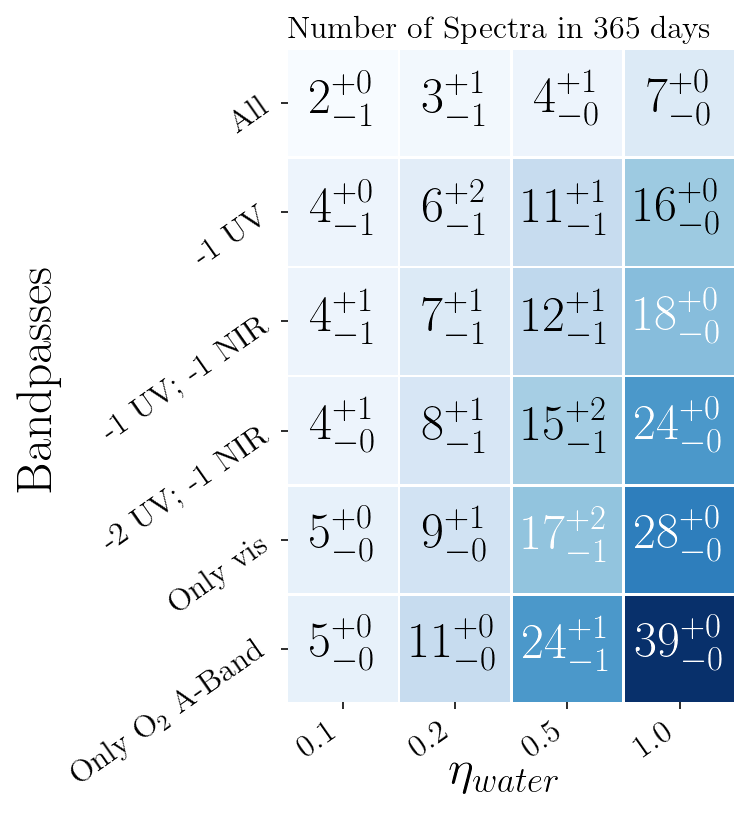

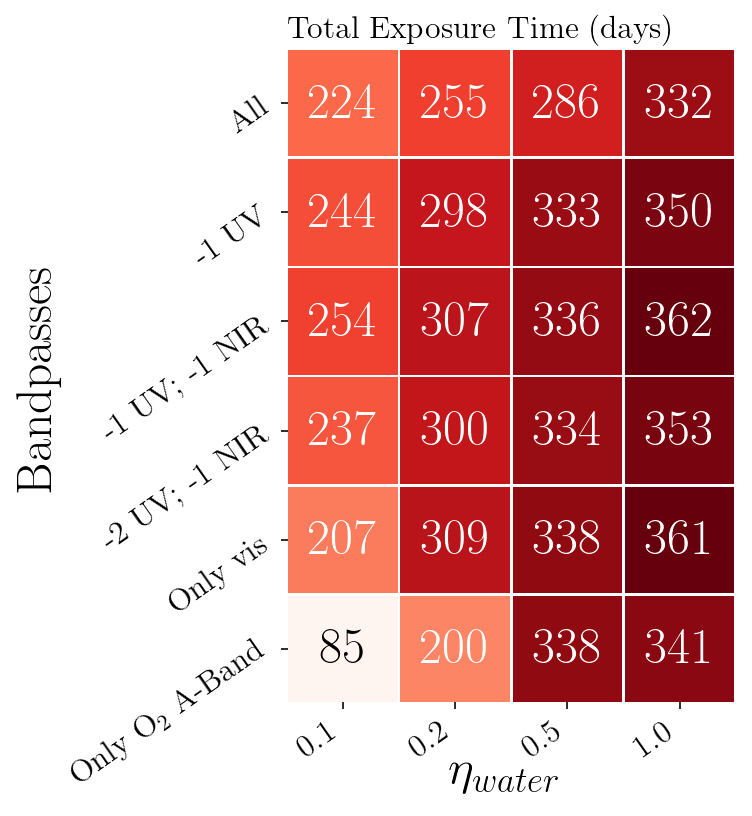

In [8]:
# Make Table of results
fig, ax = ColorTable(etas, case_names, countx[:,:,0], fmt = "%i", data_pm = (countx[:,:,1], countx[:,:,2]), labelfontsize=16, labelrotation=35, 
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01)
ax[0,0].set_title("Number of Spectra in %i days" %drmx.wantexp, ha = "left", fontsize = 16, loc = "left")

fig, ax = ColorTable(etas, case_names, t_totx[:,:,0], fmt = "%i", labelfontsize=16, labelrotation=35, colormap = "Reds",
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01, textsize = 16)
                     #data_pm = (t_totx[:,:,1], t_totx[:,:,2]))
ax[0,0].set_title("Total Exposure Time (days)", ha = "left", fontsize = 16, loc = "left")

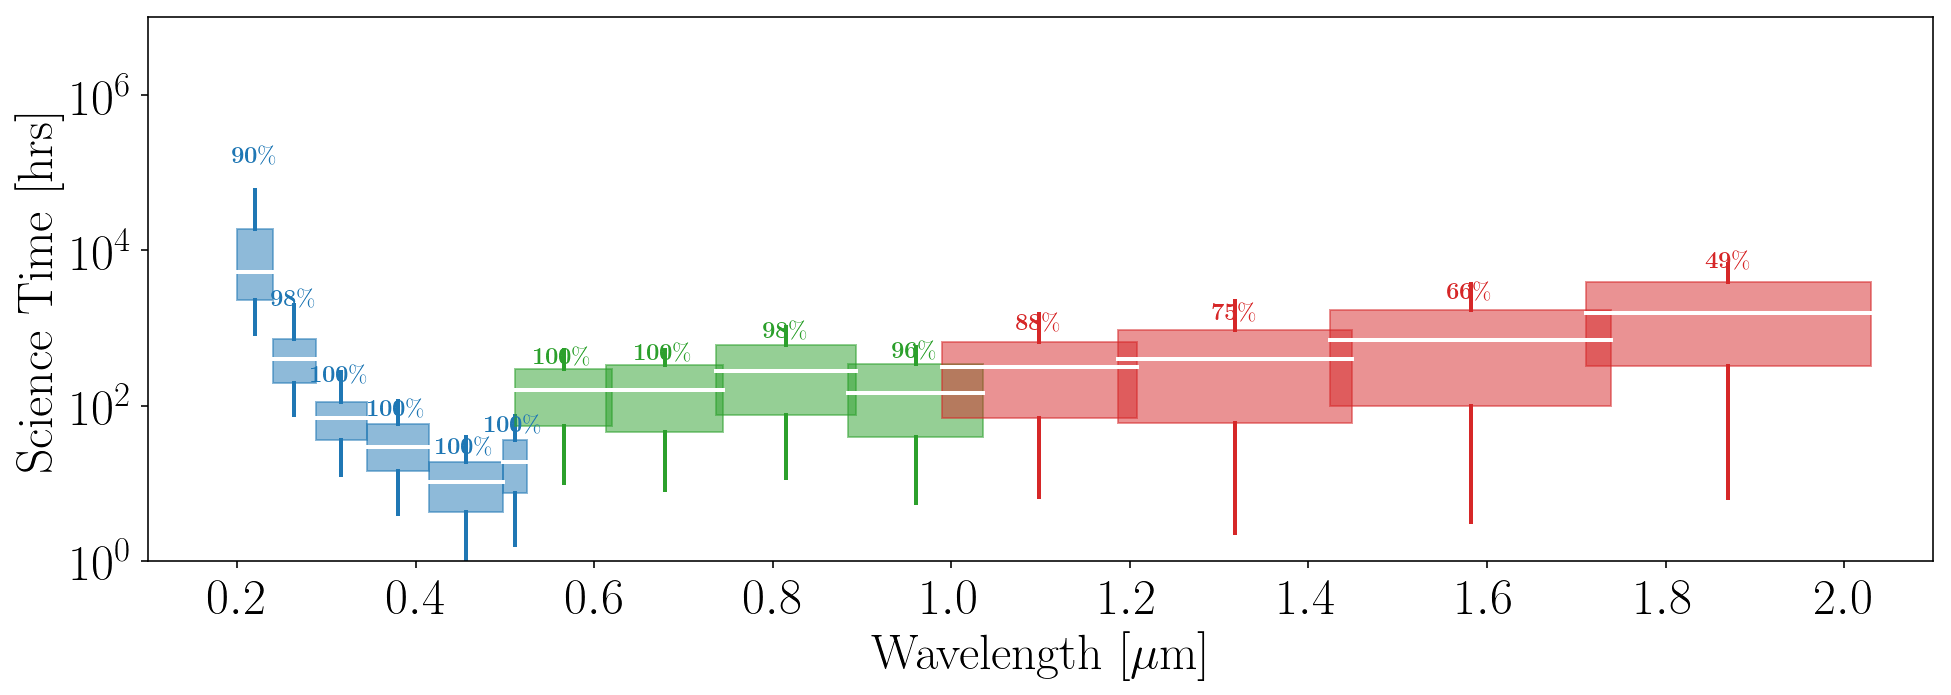

In [9]:
fig = drmx.plot_bp_exptimes(plot_spectrum=False)

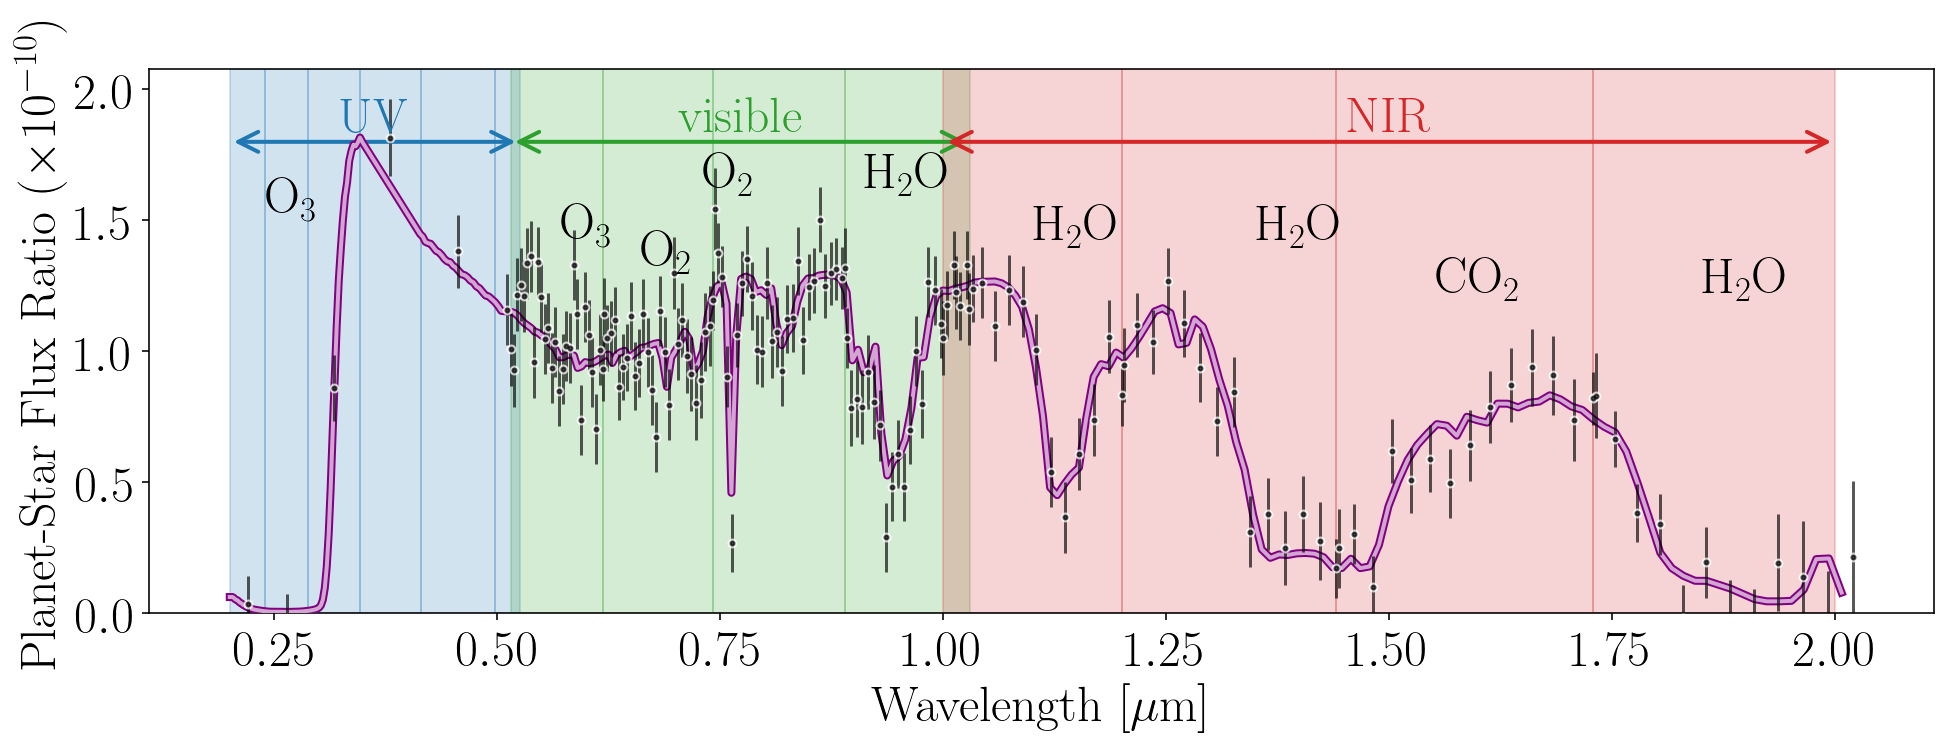

In [10]:
fig, ax = drmx.plot_observed_spectrum()

In [11]:
# Randomly draw stellar sample indices
idraw = np.random.choice(np.arange(drmx.NBIAS), size=1, replace=False)[0]

# Get exptimes
texpbp = drmx.tpbpcs_rect[idraw,:]

# Set system parameters for this star
drmx.prep_ith_star(idraw)

In [12]:
for ibp in range(len(drmx.bandpasses)):
    print(ibp, drmx.bp_names[ibp], drmx.bp_chan[ibp], drmx.bandpasses[ibp])

(0, u'UV 1', 0, array([0.2 , 0.24]))
(1, u'UV 2', 0, array([0.24 , 0.288]))
(2, u'UV 3', 0, array([0.288 , 0.3456]))
(3, u'UV 4', 0, array([0.3456 , 0.41472]))
(4, u'UV 5', 0, array([0.41472 , 0.497664]))
(5, u'UV 6', 0, array([0.497664, 0.525   ]))
(6, u'vis 1', 1, array([0.515, 0.618]))
(7, u'vis 2', 1, array([0.618 , 0.7416]))
(8, u'vis 3', 1, array([0.7416 , 0.88992]))
(9, u'vis 4', 1, array([0.88992, 1.03   ]))
(10, u'NIR 1', 2, array([1. , 1.2]))
(11, u'NIR 2', 2, array([1.2 , 1.44]))
(12, u'NIR 3', 2, array([1.44 , 1.728]))
(13, u'NIR 4', 2, array([1.728, 2.   ]))


In [13]:
j = 3
case = cases[j]
print(case_names[j])

t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = 20, 
                                                                                               verbose = True, 
                                                                                               iremove = case, 
                                                                                               wantexp_days=drmx.wantexp)

-2 UV; -1 NIR
HIP116771 - F7V - 13.71pc
    - 80.4% Complete Spectrum : 59.63 days
    - UV Spectrum : 3.63 days
    - Optical Spectrum : 27.61 days
    - NIR Spectrum : 59.63 days
    - Overhead 6.28 days
HIP32439 - F8V - 17.87pc
    - 80.4% Complete Spectrum : 157.52 days
    - UV Spectrum : 6.77 days
    - Optical Spectrum : 56.44 days
    - NIR Spectrum : 157.52 days
    - Overhead 16.07 days
HIP5862 - F8V - 15.11pc
    - 80.4% Complete Spectrum : 81.99 days
    - UV Spectrum : 4.58 days
    - Optical Spectrum : 34.67 days
    - NIR Spectrum : 81.99 days
    - Overhead 8.52 days
HIP48113 - G2V - 18.37pc
    - 51.7% Complete Spectrum : 48.18 days
    - UV Spectrum : 6.67 days
    - Optical Spectrum : 48.18 days
    - NIR Spectrum : 28.35 days
    - Overhead 5.08 days
HIP85523 - K5 - 4.54pc
    - 80.4% Complete Spectrum : 1.01 days
    - UV Spectrum : 0.70 days
    - Optical Spectrum : 0.73 days
    - NIR Spectrum : 0.32 days
    - Overhead 0.42 days
HIP15371 - G1V - 12.03pc
    - 80

In [87]:
ibp = 8

itarget = 1
drmx.tpbpcs_rect[idraw, ibp]
N =  int(np.ceil(tpbpcs_draws[itarget,ibp])) 
tpbpcs_draws[itarget,ibp], int(np.ceil(tpbpcs_draws[itarget,ibp]))

(21.029076459615702, 22)

In [29]:
which_earth = "True_Earth"
which_phase = 90.

ibp = 8
channel = spectroscopy.CHANNELS[drmx.bp_chan[ibp]]
telescope = spectroscopy.default_luvoir(architecture=drmx.architecture, channel=channel)
telescope.lammin = drmx.bandpasses[ibp][0]
telescope.lammax = drmx.bandpasses[ibp][1]

# Starting index
istart = 0
# Set number of consecutive exposures
#N = 100
# Set the integration time per exposure
iN = 1
# Set number of neighboring pixels to coadd (int or "all")
iM = "all"

# Instantiate DataGenerator object with EarthModel data
data = DataGenerator(earth_model = EarthModel())

# Select the Earth Model dataset with HDF5 file
data.select_dataset(which_earth = which_earth, which_phase = which_phase)

# Set default telescope, planet and star
#data.set_default_observing_system()
data.telescope = telescope
data.planet = drmx.cn.planet
data.star = drmx.cn.star

# Create default dataset
data.create_mock_dataset(istart = istart, N = N, iN = iN, iM = iM, 
                         imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

HDF5 file opened


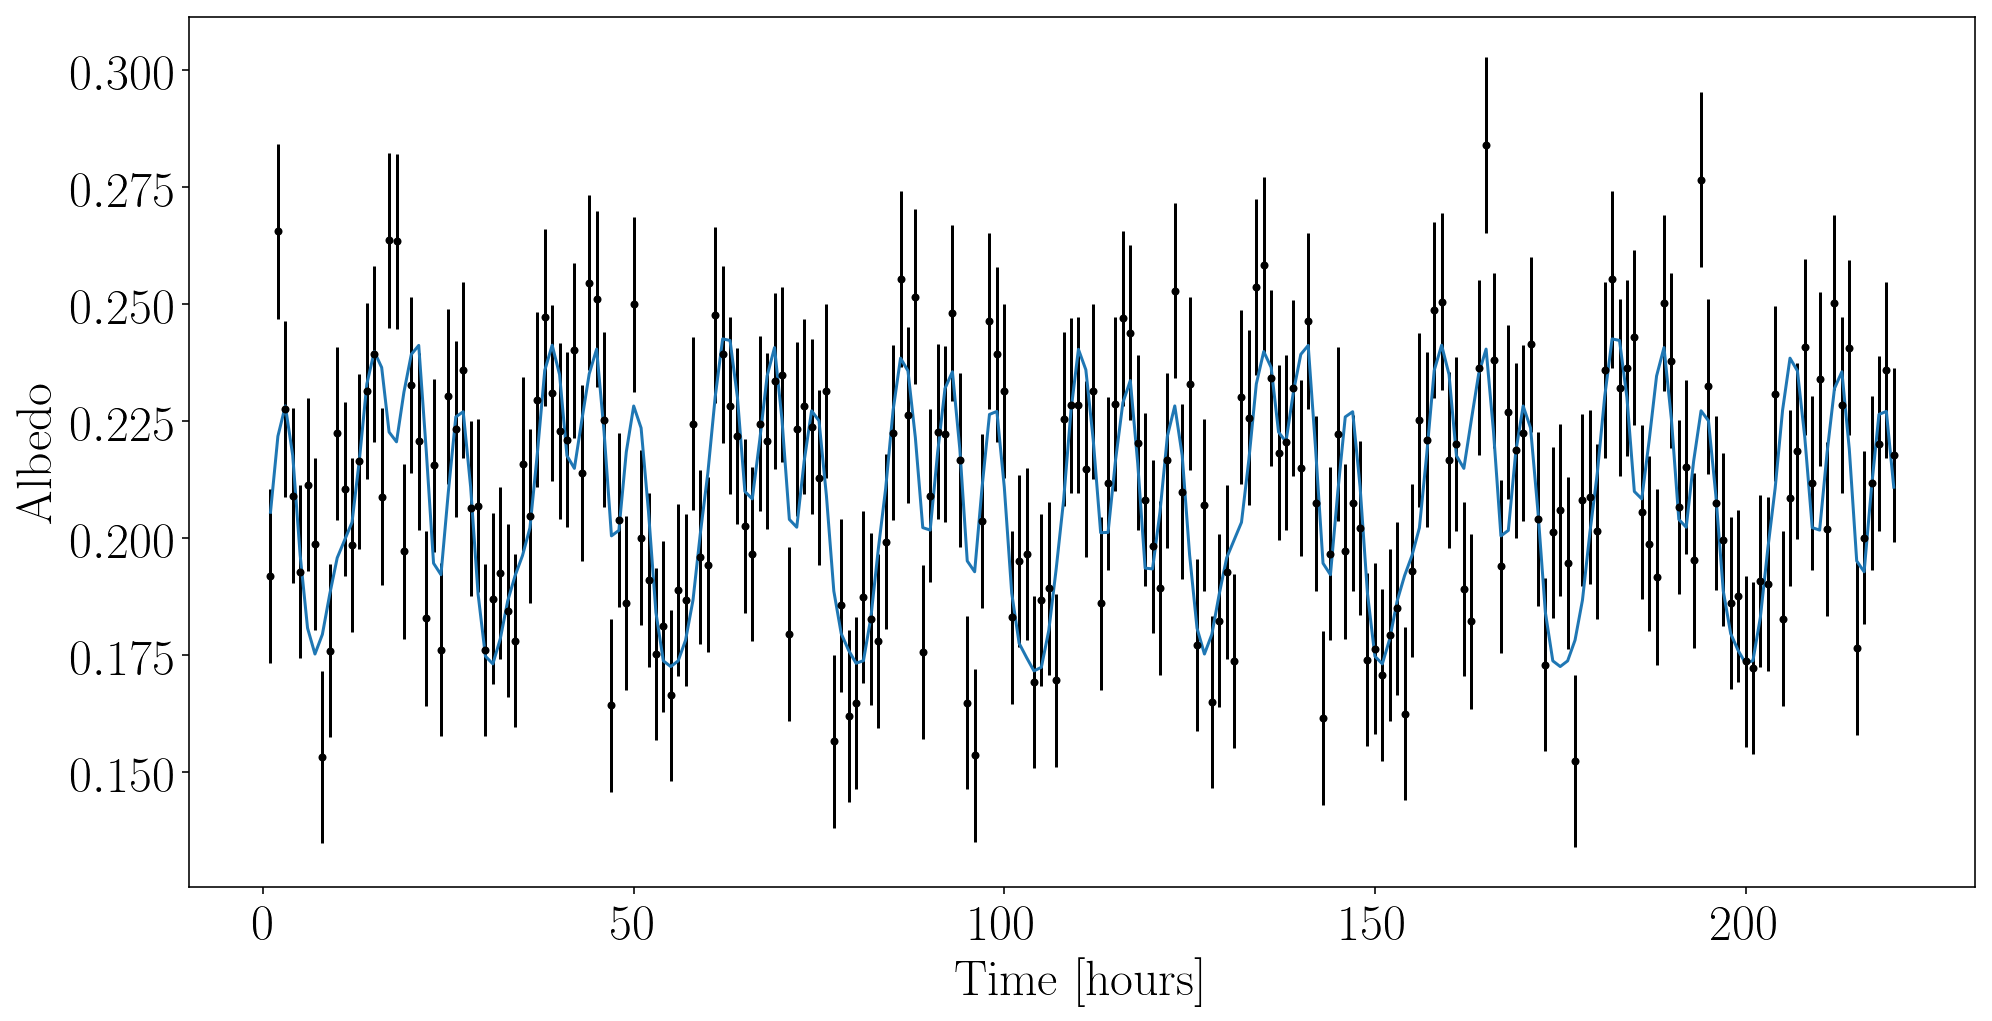

In [30]:
x = data.times
y = data.obs[:,0]
yt = data.A[:,0]
yerr = data.sig[:,0]

fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Albedo")
ax.errorbar(x, y, yerr=yerr, fmt=".", color = "k")
ax.plot(x, yt, color = "C0")

In [138]:
drmx.tpbpcs_rect[:,7]

array([  44.01098736,    2.9813171 ,   74.89766527,   12.81896903,
         56.3734147 ,  138.69532828,   32.72254079,   32.76976259,
        299.64269342,   21.78669715,  182.1406306 , 1224.66238354,
         91.52403254,   25.95590866,    8.29594217,  145.33145994,
         44.91411996,    2.29140365,  173.15097507,   15.16352315,
        197.43967598,   64.70517276,    4.19212916,   87.02632464,
        159.94425892,   30.1790116 ,   45.32463121,  198.30117969,
         54.28969735,  334.47691912,  171.20617427,  334.13295096,
        519.20445784,  382.13330802,   74.12667428,  490.53654511,
        459.63968465,  525.09760971,   71.5257854 ,  128.67669962,
        761.05642597,  237.26280661,  609.6322753 ,  475.6479011 ,
        382.52112042,  219.14339299,  195.17405224,  127.37996579,
        376.64253615,  194.35396792,  447.46338707,  276.99666418,
        400.29188508])

In [124]:
itarget = 4
tpbpcs_draws[itarget,:], np.ceil(tpbpcs_draws[itarget,:])

(array([2.99256251e+04, 7.26309361e+02, 6.39716536e+01, 2.00569734e+01,
        5.25713980e+00, 9.05529765e+00, 7.32867640e+01, 6.47051728e+01,
        1.06009785e+02, 5.04033161e+01, 1.13536546e+02,            nan,
                   nan,            nan]),
 array([2.9926e+04, 7.2700e+02, 6.4000e+01, 2.1000e+01, 6.0000e+00,
        1.0000e+01, 7.4000e+01, 6.5000e+01, 1.0700e+02, 5.1000e+01,
        1.1400e+02,        nan,        nan,        nan]))

In [225]:
# Randomly draw stellar sample indices
idraw = np.random.choice(np.arange(drmx.NBIAS), size=1, replace=False)[0]

# Get exptimes
texpbp = drmx.tpbpcs_rect[idraw,:]

# Set system parameters for this star
drmx.prep_ith_star(idraw)

# 
icase = 4
case = cases[icase]

print(drmx.cn.planet)
print(drmx.cn.star)
print(case_names[icase], case)

for i in range(len(drmx.bp_names)):
    print("%s : %.0f hours" %(drmx.bp_names[i], np.ceil(texpbp[i])))

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0
Star: 
-----
- Effective Temperature (K) : 4900.0
- Radius (Solar Radii) : 1.05
('Only vis', array([ 0,  1,  2,  3,  4,  5, 10, 11, 12, 13]))
UV 1 : 29926 hours
UV 2 : 727 hours
UV 3 : 64 hours
UV 4 : 21 hours
UV 5 : 6 hours
UV 6 : 10 hours
vis 1 : 74 hours
vis 2 : 65 hours
vis 3 : 107 hours
vis 4 : 51 hours
NIR 1 : 114 hours
NIR 2 : nan hours
NIR 3 : nan hours
NIR 4 : nan hours


HDF5 file opened
HDF5 file opened
HDF5 file opened
HDF5 file opened


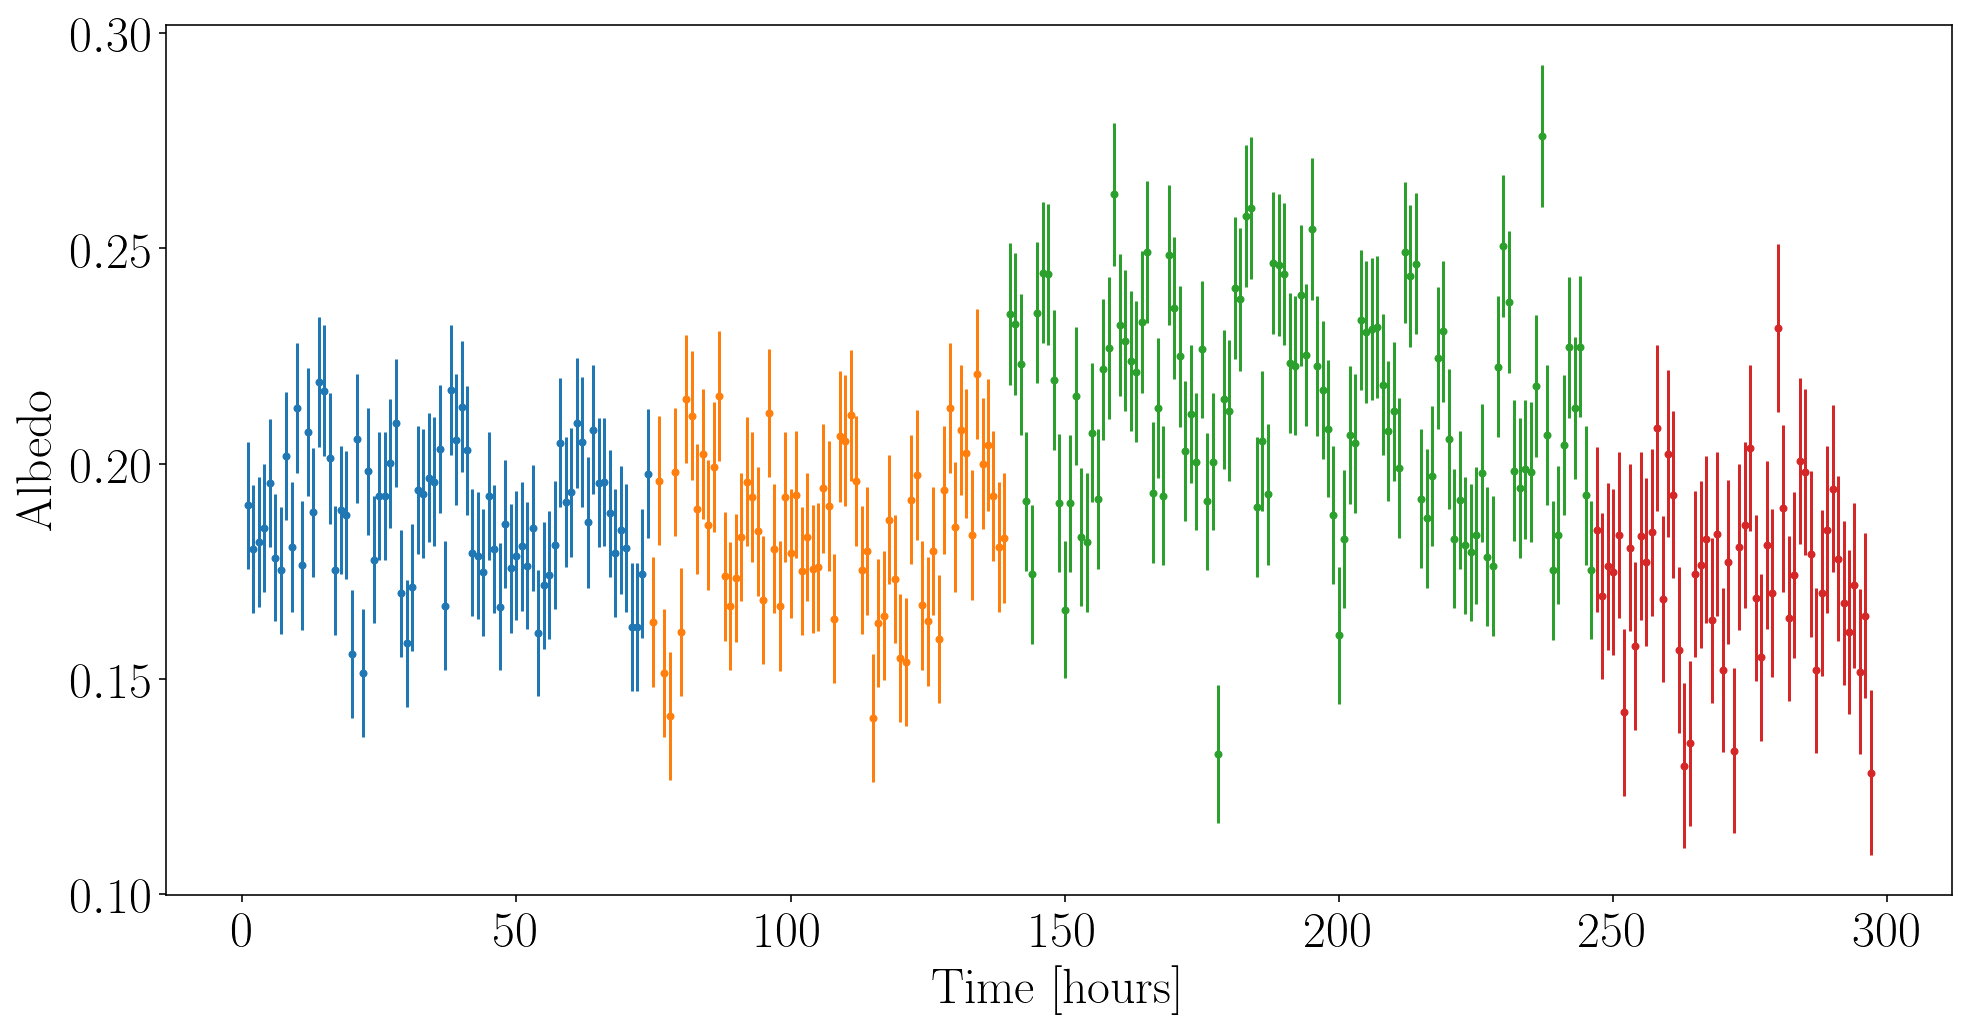

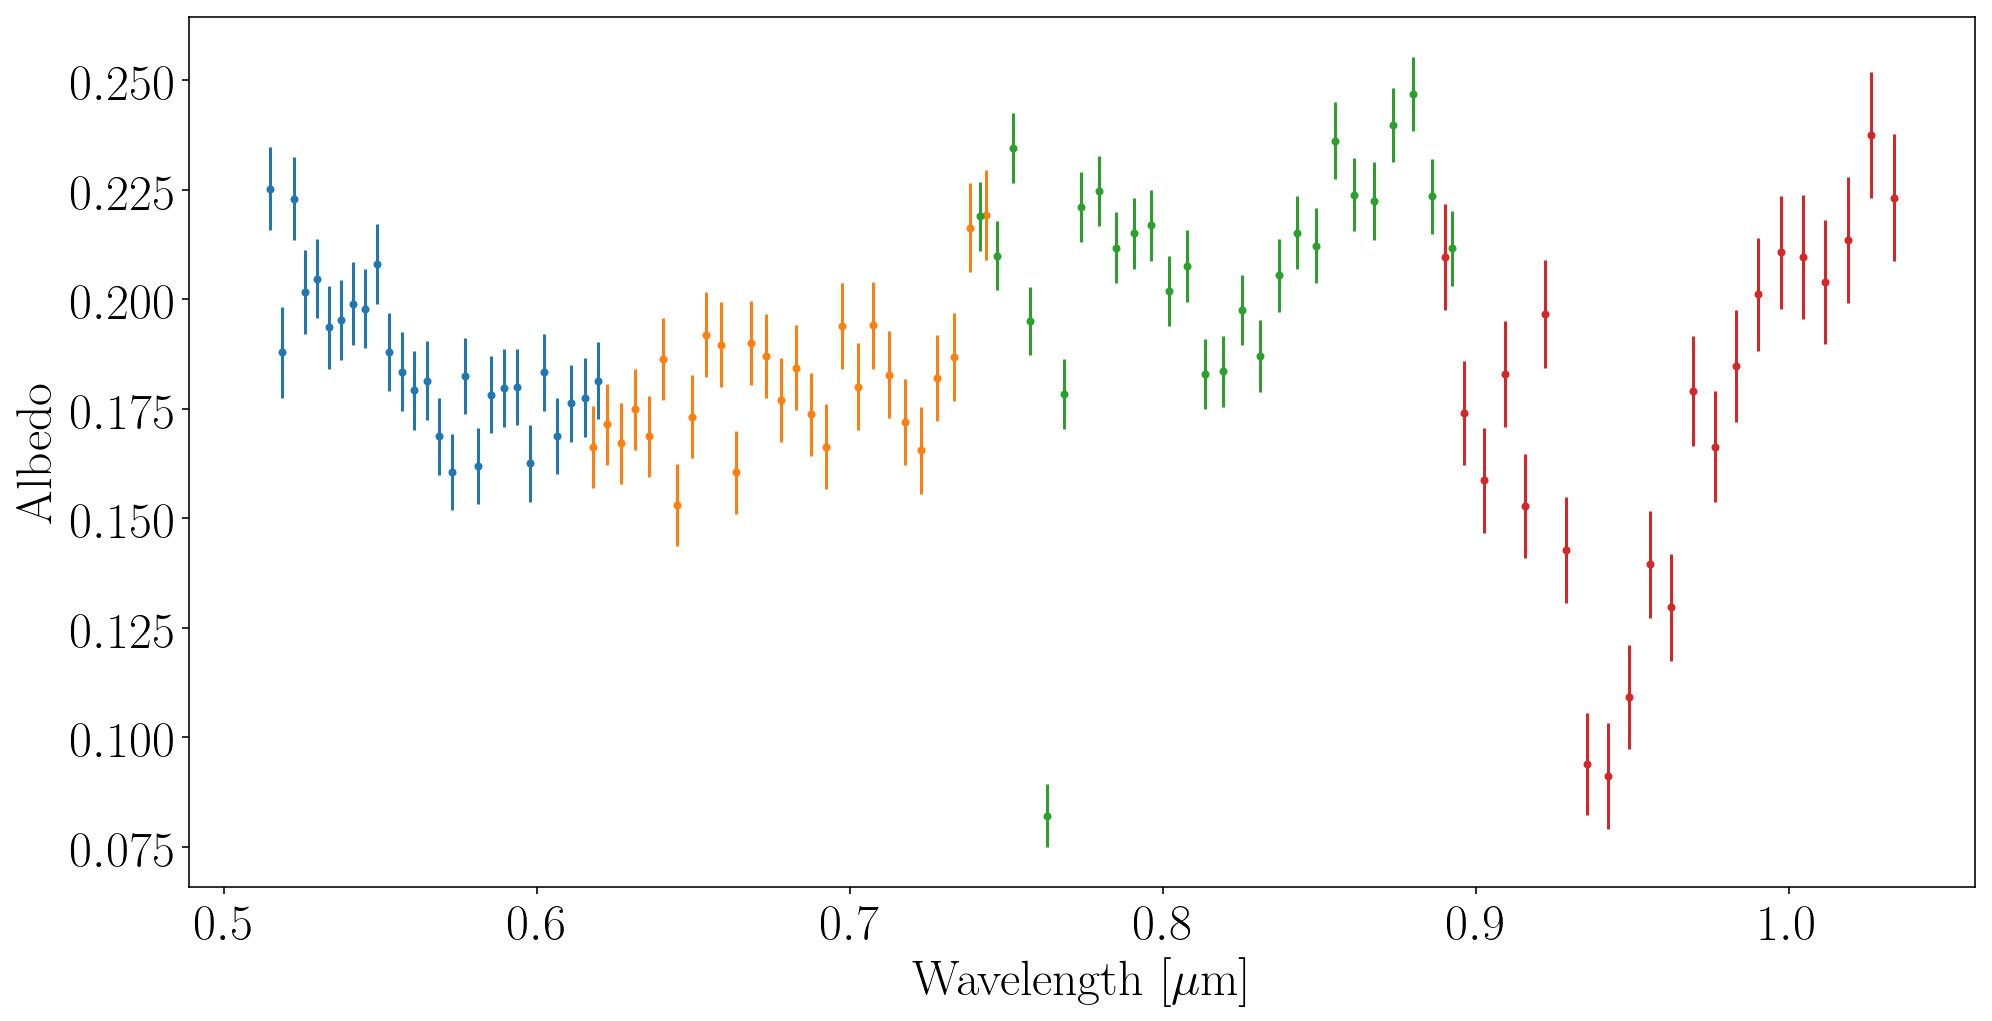

In [277]:
fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Albedo")

fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("Albedo")

# Starting index
istart = 0

ts = []
ys = []
dys = []
bps = []

lams = []
Aobs = []
Asigs = []
Atrus = []
SNRs = []

for ibp in range(len(drmx.bandpasses)):
    
    if np.isfinite(texpbp[ibp]):
        Ntexp = int(np.ceil(texpbp[ibp]))
    else:
        Ntexp = np.nan
    
    if (ibp not in case) and (np.isfinite(Ntexp)):

        which_earth = "True_Earth"
        which_phase = 90.

        channel = spectroscopy.CHANNELS[drmx.bp_chan[ibp]]
        telescope = spectroscopy.default_luvoir(architecture=drmx.architecture, channel=channel)
        telescope.lammin = drmx.bandpasses[ibp][0]
        telescope.lammax = drmx.bandpasses[ibp][1]


        # Set number of consecutive exposures
        #N = 100
        N =  Ntexp

        # Set the integration time per exposure
        iN = 1

        # Set number of neighboring pixels to coadd (int or "all")
        iM = "all"

        # Instantiate DataGenerator object with EarthModel data
        data = DataGenerator(earth_model = EarthModel())

        # Select the Earth Model dataset with HDF5 file
        data.select_dataset(which_earth = which_earth, which_phase = which_phase)

        # Set default telescope, planet and star
        #data.set_default_observing_system()
        data.telescope = telescope
        data.planet = drmx.cn.planet
        data.star = drmx.cn.star

        # Create timeseries dataset
        data.create_mock_dataset(istart = istart, N = N, iN = iN, iM = iM, 
                                 imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])

        x = data.times + istart
        y = data.obs[:,0]
        yerr = data.sig[:,0]
        ax.errorbar(x, y, yerr=yerr, fmt=".")
        
        ts.append(x)
        ys.append(y)
        dys.append(yerr)
        bps.append([drmx.bp_names[ibp] for _ in x] )
        
        # Create spectrum dataset
        data2 = copy.copy(data)
        data2.create_mock_dataset(istart = istart, N = N, iN = iN, iM = 1, 
                                  imod = data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"].shape[0])
        
        # Use Modify exposure to temporally coadd entire dataset at the spectrograph's native resolution
        times_new, A_new, obs_new, sig_new, SNR_new = ForwardMethods.modify_exposure(data2.A, data2.SNR, window = data2.N,
                                                     og_texp = 1.,
                                                     snr_method = "coadd",
                                                     verbose = False, time_ref = "right")
        
        ax2.errorbar(data2.lam[0,:], obs_new[0,:], yerr=sig_new[0,:], fmt = ".")
        
        lams.append(data2.lam[0,:])
        Aobs.append(obs_new[0,:])
        Asigs.append(sig_new[0,:])
        Atrus.append(A_new[0,:])
        SNRs.append(SNR_new[0,:])
        
        istart += N

In [34]:
import gatspy 

In [272]:
# Using the LombScargleMultiband
lsmodel = gatspy.periodic.LombScargleMultiband(fit_period=True)

In [273]:
# Specify valid period range to search
lsmodel.optimizer.period_range=(1.2, 50.0)

```python
# Example code for data shape
rrlyrae = gatspy.datasets.fetch_rrlyrae()
t, mag, dmag, filts = rrlyrae.get_lightcurve(rrlyrae.ids[0])
```

In [274]:
# Coerce "data" into LombScargleMultiband format
t = np.hstack(ts)
y = np.hstack(ys)
dy = np.hstack(dys)
filts = np.hstack(bps)

In [275]:
# Fit periodogram
lsmodel.fit(t, y, dy, filts)

# Get best period
best_period = lsmodel.best_period
best_period

Finding optimal frequency:
 - Estimated peak width = 0.0212
 - Using 5 steps per peak; omega_step = 0.00425
 - User-specified period range:  1.2 to 50
 - Computing periods at 1205 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


24.59697523682899

Text(0.1,0.5,'Relative Albedo')

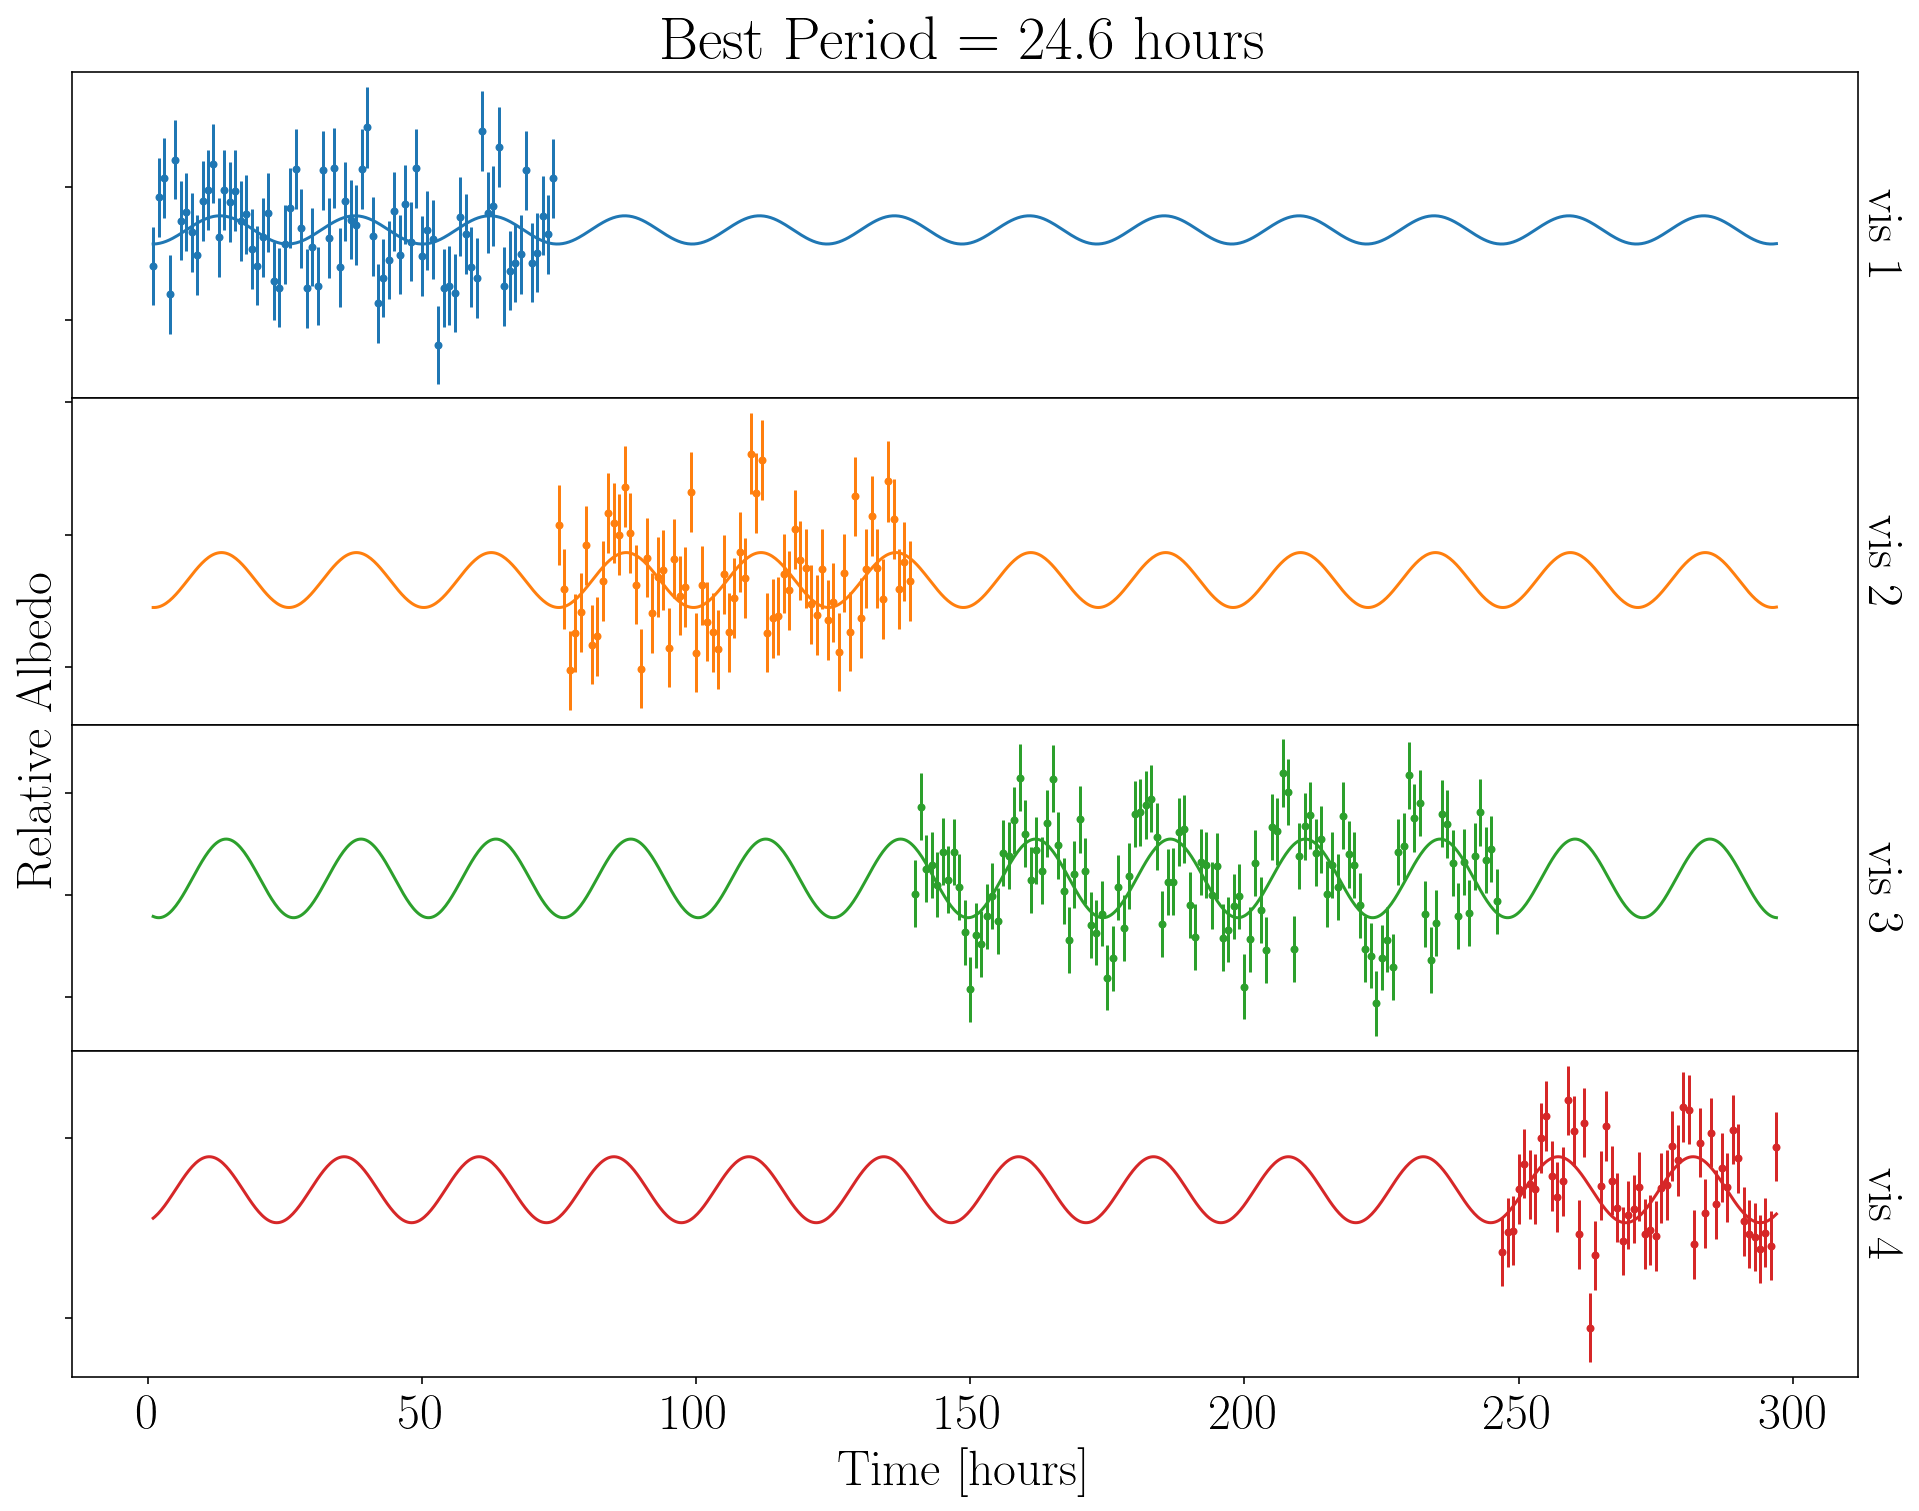

In [276]:
fig, ax = plt.subplots(len(bps), 1, figsize = (16,3*len(bps)), gridspec_kw={"hspace" : 0})
#ax.set_xlabel("Time [hours]")
#ax.set_ylabel("Albedo")

ax[0].set_title("Best Period = %.1f hours" %best_period)

tfit = np.linspace(np.min(t), np.max(t), 1000)

for i in range(len(bps)):

    yfit = lsmodel.predict(tfit, filts=bps[i][0])
    
    ax[i].errorbar(ts[i], ys[i], yerr=dys[i], fmt=".", color = "C%i" %(i%9))
    ax[i].plot(tfit, yfit, color = "C%i" %(i%9))
    ax[i].text(1.0, 0.5, bps[i][0], ha = "left", va = "center", transform=ax[i].transAxes, rotation = 270)
    ax[i].set_yticklabels([])

ax[i].set_xlabel("Time [hours]")
ylabel_spacing = 0.1
fig.text(ylabel_spacing, 0.5, "Relative Albedo", ha = "left", va = "center",
            fontsize=mpl.rcParams['font.size'], zorder=10, rotation = 90,
            bbox=dict(boxstyle="square", fc="none", ec="none"))

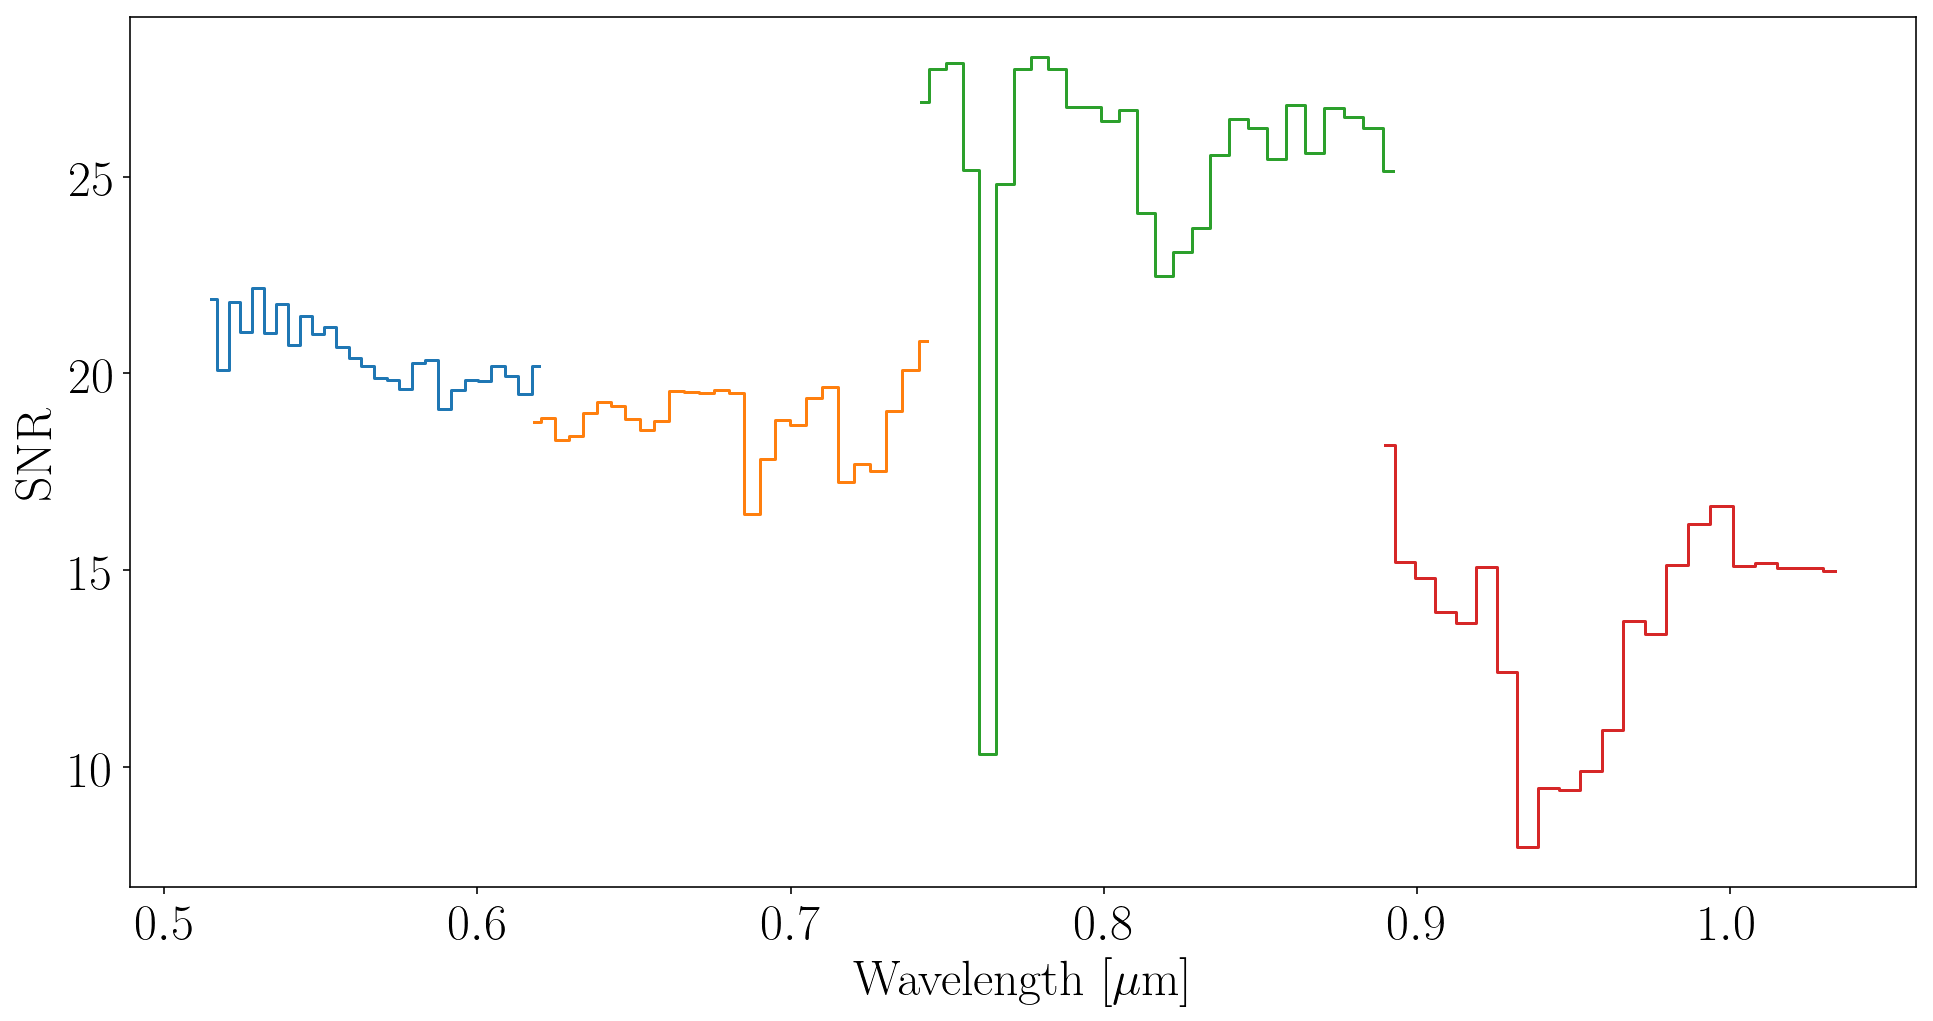

In [283]:
fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("SNR")

for i in range(len(bps)):
    ax2.plot(lams[i], SNRs[i], ls = "steps-mid")

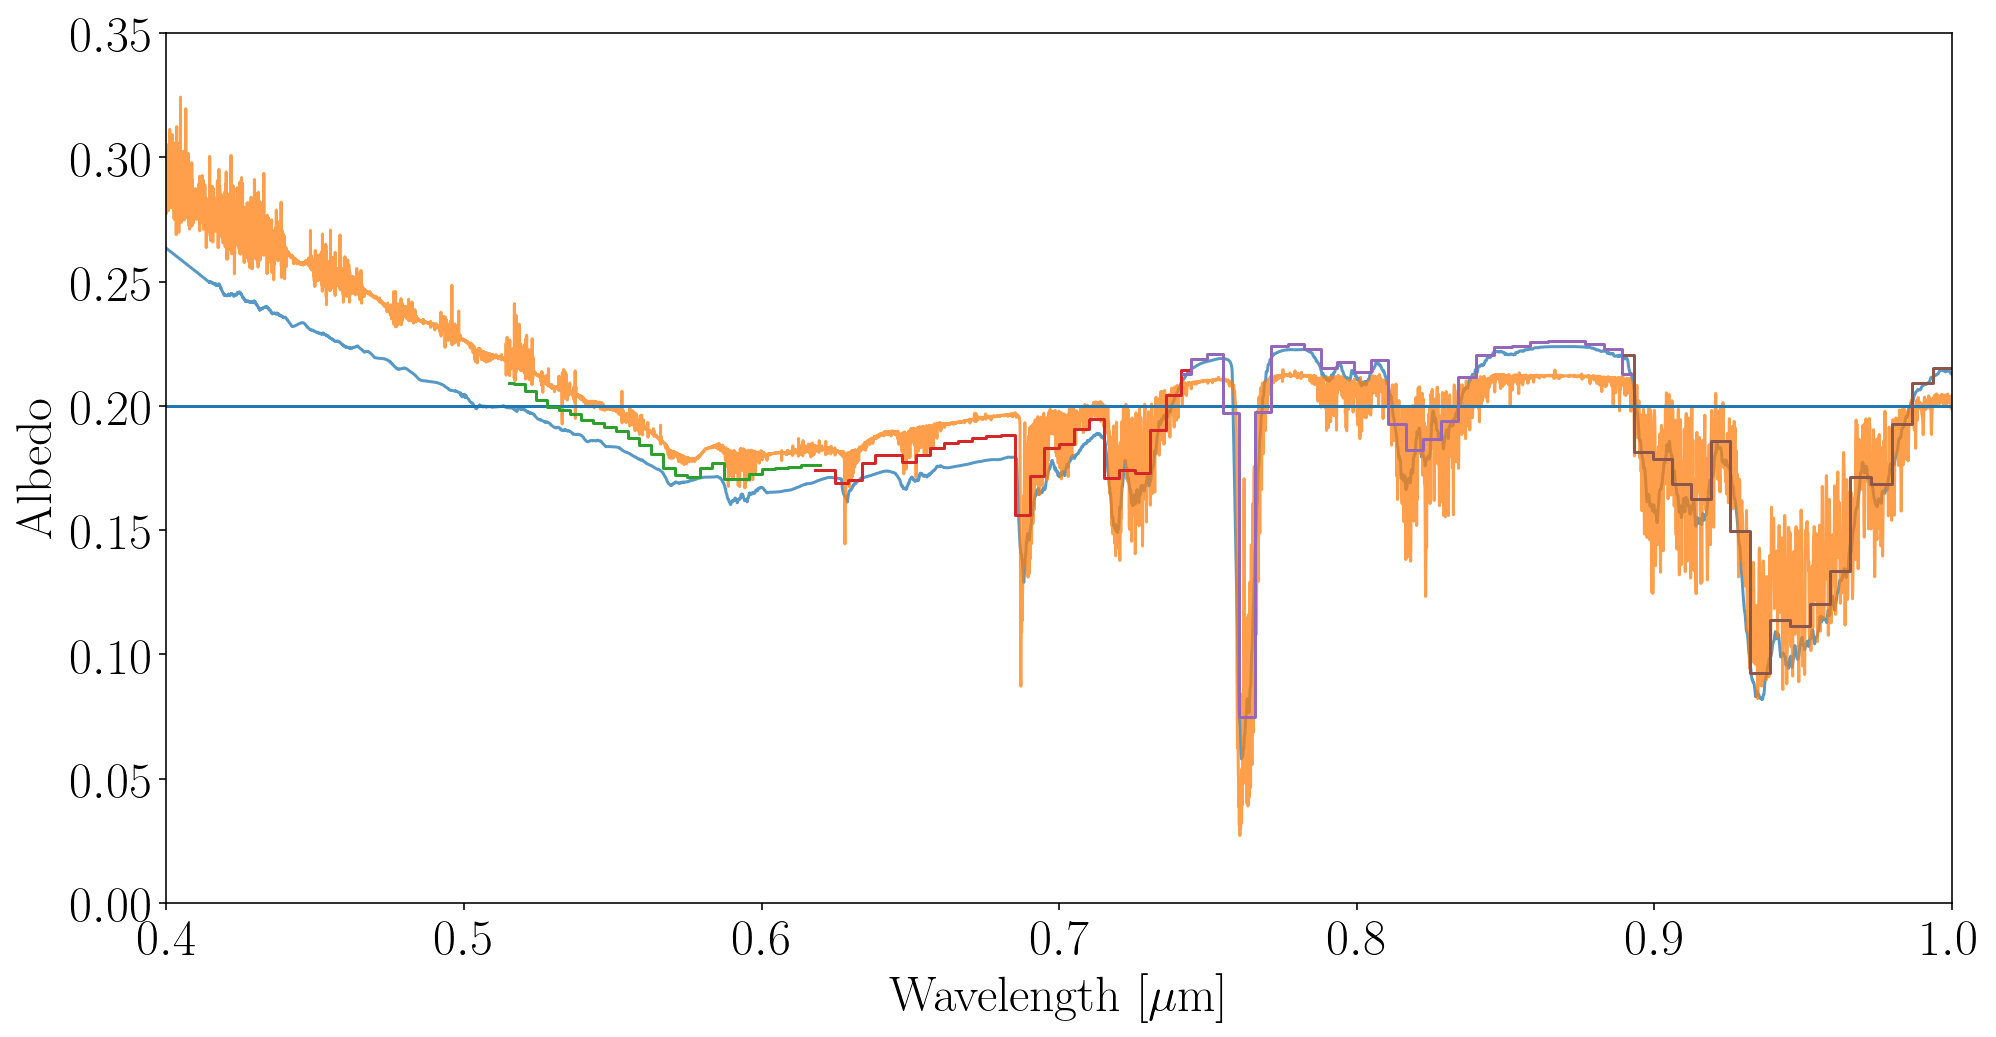

In [330]:
fig2, ax2 = plt.subplots(figsize = (16,8))
ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylabel("Albedo")

ax2.set_xlim(0.4, 1.0)
ax2.set_ylim(0.0, 0.35)

ax2.plot(drmx.LAMHR, drmx.AHR, alpha=0.75)

ax2.plot(data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/wavelength"], 
         np.pi*data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"][10,:] / data.planet.Phi, 
         alpha = 0.75)

ax2.axhline(drmx.Ahr_flat)

for i in range(len(bps)):
    ax2.plot(lams[i], Atrus[i], ls = "steps-mid")

In [297]:
Ahr_flat  = drmx.Ahr_flat * np.ones(len(drmx.LAMHR))

# Run count rates (necessary to generate new wavelength grid)
drmx.cn.run_count_rates(Ahr_flat, drmx.LAMHR, drmx.cn.solhr)

In [310]:
data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"]

<HDF5 dataset "albedo": shape (120, 91999), type "<f4">

In [311]:
np.pi*data.earth_model.hfile["True_Earth/geom_equatorial_90deg/reflectance/albedo"][0,:] / data.planet.Phi

array([3.3782821e+00, 3.4126220e+00, 3.3969946e+00, ..., 1.7698518e-06,
       1.7686009e-06, 1.7673541e-06], dtype=float32)

In [332]:
print(drmx.cn.planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [331]:
print(data.planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 12.4938
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 0.7576617601771974
- Phase angle (deg) : 90.00000250447816
- Lambertian phase function : 0.318309864328096
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [289]:
print(drmx.cn.telescope)

Coronagraph: 
------------
- Telescope observing mode : IFS
- Minimum wavelength (um) : 0.2
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 140.0 
- Telescope/System temperature (K)  : 270.0 
- Detector temperature (K)  : 50.0 
- Telescope diameter (m)  : 15.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 3.5 
- Outer Working Angle (lambda/D)  : 64.0 
- Telescope throughput  : 0.18 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.002 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 2.5 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.675


In [291]:
np.pi / data.planet.Phi

9.869605078753121